In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor 
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import time
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer, MissingIndicator

df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df.head(3)

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker

# Visualization

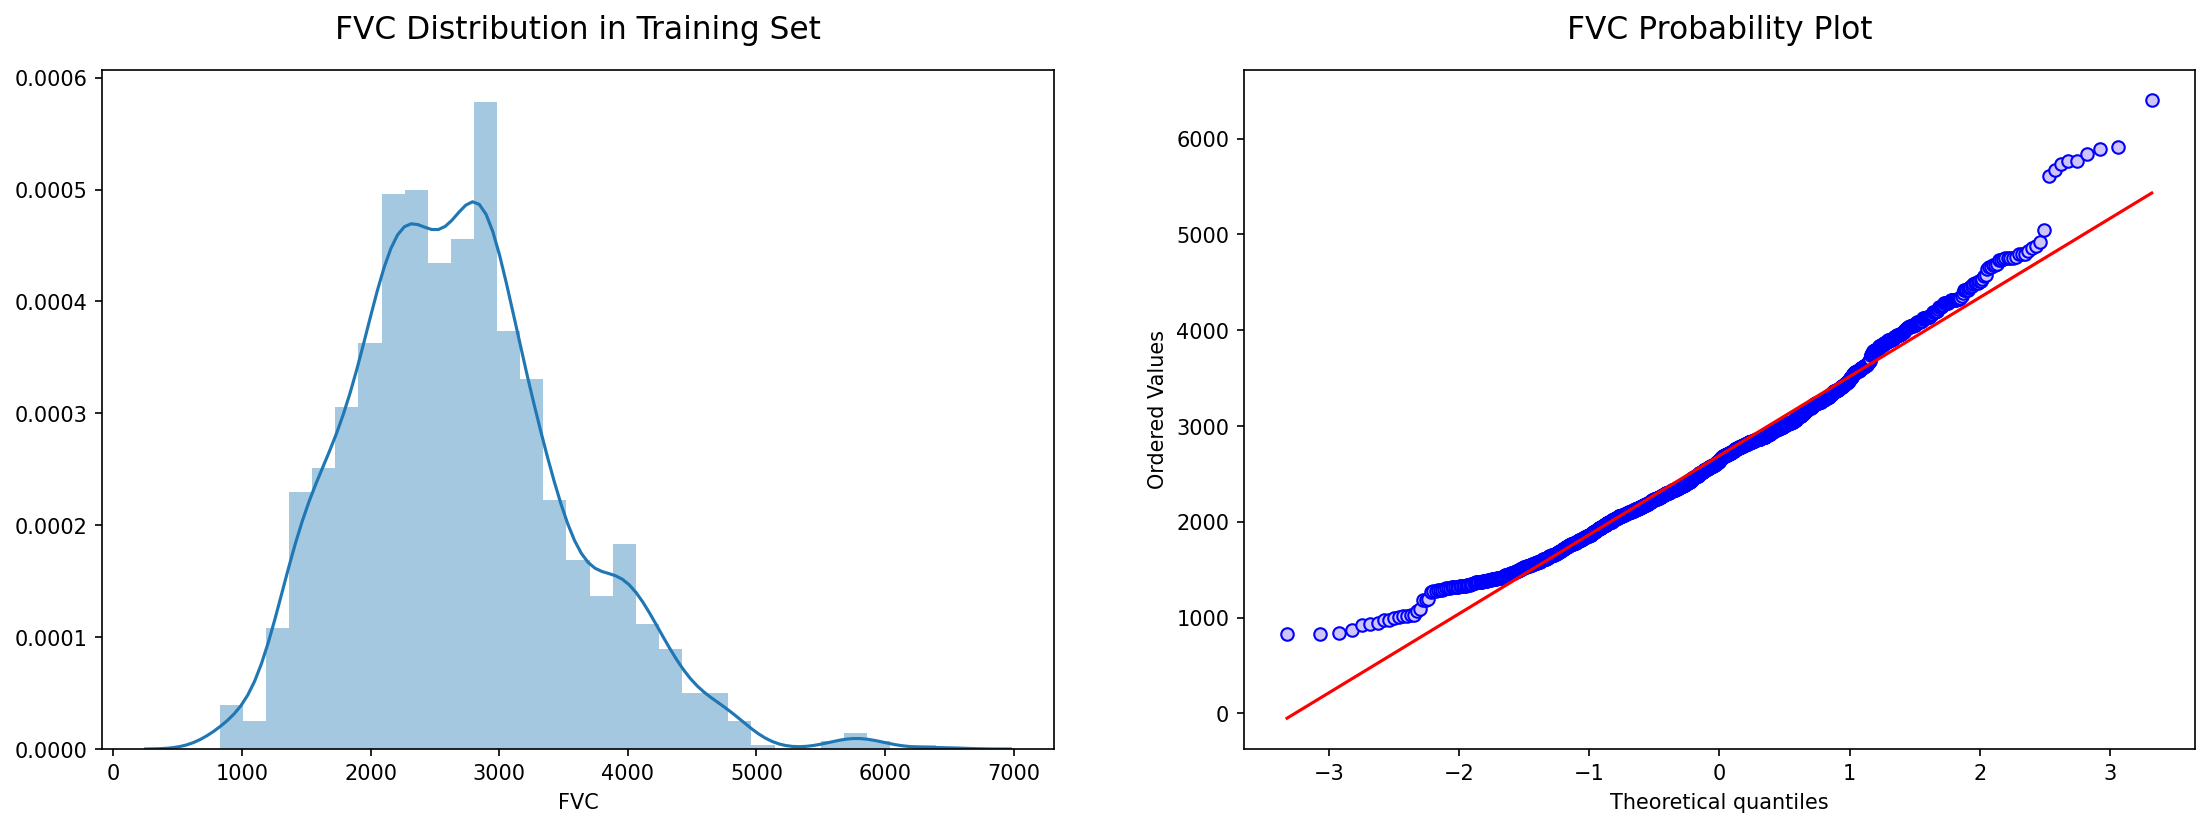

In [2]:
from scipy import stats

fig, axes = plt.subplots(ncols=2, figsize=(18, 6), dpi=150)
sns.distplot(df['FVC'], label='FVC', ax=axes[0])
stats.probplot(df['FVC'], plot=axes[1])
axes[0].set_title(f'FVC Distribution in Training Set', size=15, pad=15)
axes[1].set_title(f'FVC Probability Plot', size=15, pad=15)
axes[1].get_lines()[0].set_markerfacecolor('#cfc4f8')

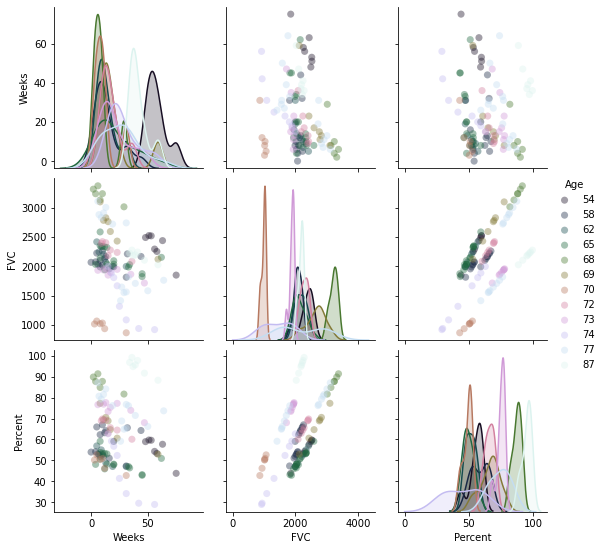

In [3]:
sample_ids = pd.DataFrame(df['Patient'].value_counts().tail(15)).reset_index()
sample_id_list = sample_ids['index'].tolist()
fifteen_patients_df = df[df['Patient'].isin(sample_id_list)]

g = sns.pairplot(fifteen_patients_df, hue="Age", palette="cubehelix",
                 diag_kind="kde",
                 plot_kws=dict(s=50, edgecolor="none", linewidth=1, alpha=0.4),
                 diag_kws=dict(shade=True))

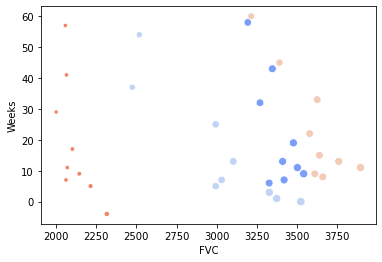

In [4]:
five_patients_df = df[(df['Patient'] == 'ID00007637202177411956430') | (df['Patient'] == 'ID00009637202177434476278') |(df['Patient'] == 'ID00010637202177584971671') |(df['Patient'] == 'ID00011637202177653955184')]

sns.scatterplot(x="FVC", y="Weeks", data=five_patients_df, hue="Patient",size="Percent", alpha=1, legend=False, palette="coolwarm_r")

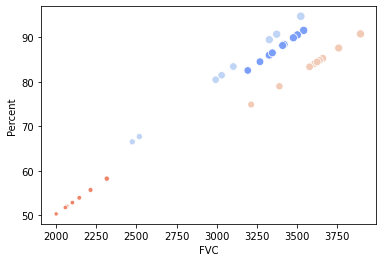

In [5]:
sns.scatterplot(x="FVC", y="Percent", data=five_patients_df, hue="Patient",size="Percent", legend=False, palette = "coolwarm_r")

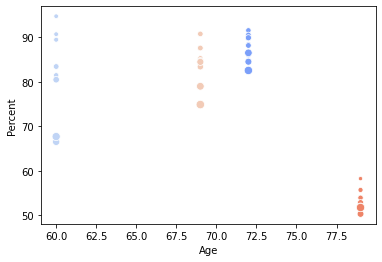

In [6]:
x = sns.scatterplot(x="Age", y="Percent", data=five_patients_df, hue = 'Patient', palette = "coolwarm_r", legend = False, size='Weeks')

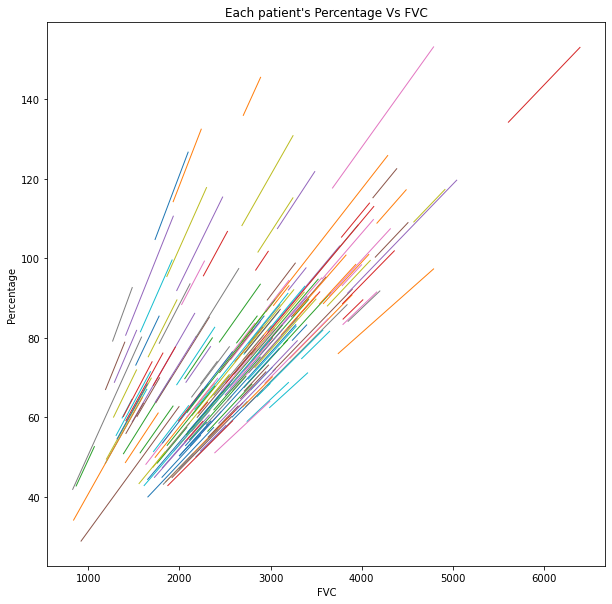

In [7]:
raw_data = df
patient_ids=df.Patient.unique()
patient_week=[]
patient_fvc=[]
patient_percentage=[]
for ids in patient_ids:
    week=raw_data.loc[raw_data['Patient']==ids]['Weeks'].values
    fvc=raw_data.loc[raw_data['Patient']==ids]['FVC'].values
    percent=raw_data.loc[raw_data['Patient']==ids]['Percent'].values
    patient_week.append(week)
    patient_fvc.append(fvc)
    patient_percentage.append(percent)

plt.figure(figsize=(10,10))
plt.title("Each patient's Percentage Vs FVC")
plt.xlabel('FVC')
plt.ylabel('Percentage')
for i in range(len(patient_ids)):
    sns.lineplot(x=patient_fvc[i],y=patient_percentage[i],label ='P'+str(i+1),lw=1,legend=False)

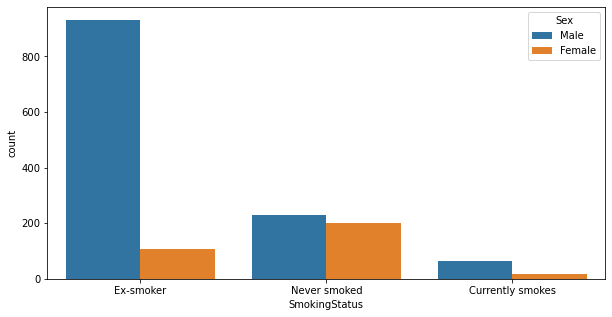

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='SmokingStatus', hue='Sex')

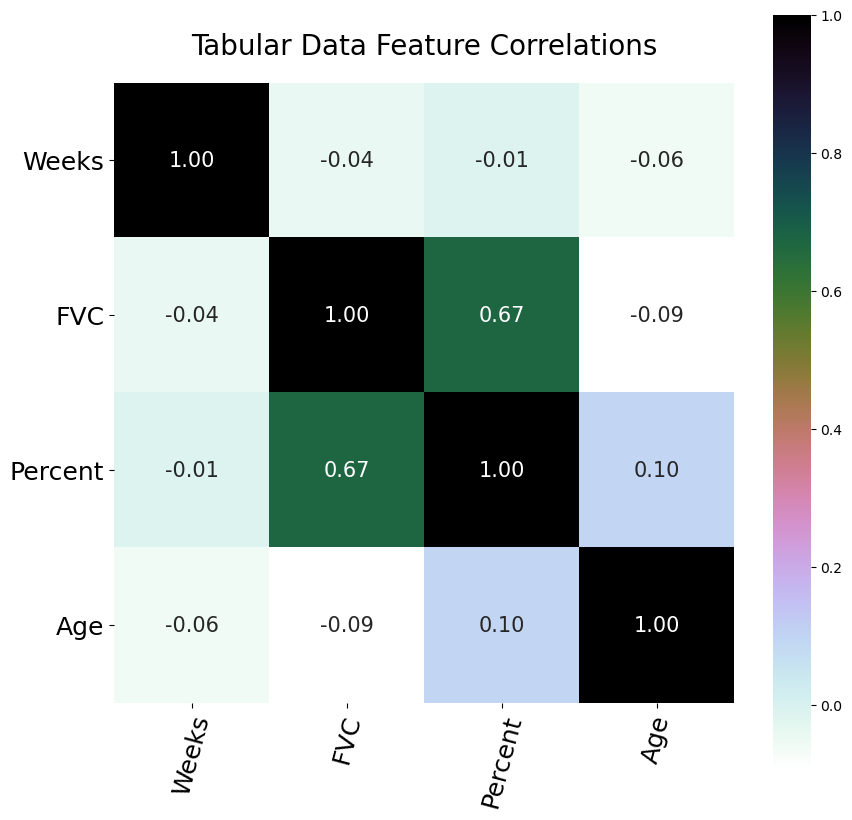

In [9]:
fig = plt.figure(figsize=(10, 10), dpi=100)

sns.heatmap(df.corr(), annot=True, square=True, annot_kws={'size': 15},  fmt='.2f', cmap="cubehelix_r")   

plt.tick_params(axis='x', labelsize=18, rotation=75)
plt.tick_params(axis='y', labelsize=18, rotation=0)
plt.title('Tabular Data Feature Correlations', size=20, pad=20)

plt.show()

# Prediction

In [10]:
df.head(2)

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker

In [11]:
max_Percent = df[['Patient','Percent']].sort_values('Percent', ascending=False).drop_duplicates(['Patient'])
min_Percent = df[['Patient','Percent']].sort_values('Percent', ascending=True).drop_duplicates(['Patient'])
max_Weeks = df[['Patient','Weeks']].sort_values('Weeks', ascending=False).drop_duplicates(['Patient'])
min_Weeks = df[['Patient','Weeks','Percent']].sort_values('Weeks', ascending=True).drop_duplicates(['Patient'])

df = pd.merge(df, max_Percent, how='left', on=['Patient'], suffixes=(None, '_max'))
df = pd.merge(df, min_Percent, how='left', on=['Patient'], suffixes=(None, '_at_Weeks_min',))
df = pd.merge(df, max_Weeks, how='left', on=['Patient'], suffixes=(None, '_max'))
df = pd.merge(df, min_Weeks, how='left', on=['Patient'], suffixes=(None, '_min'))

# df['Weekly_Avg_Percent_Change'] = (df['Percent_max'] - df['Percent_min']) / (df['Weeks_max'] - df['Weeks_min']) * -1

age = df['Age'].min()
converted_age = getattr(age, "tolist", lambda: age)()
df['Age_Scaled'] = df['Age'].astype(int) - converted_age

df.tail(2)

Patient  Weeks   FVC    Percent  Age   Sex  \
1547  ID00426637202313170790466     43  2975  73.052745   73  Male   
1548  ID00426637202313170790466     59  2774  68.117081   73  Male   

     SmokingStatus  Percent_max  Percent_at_Weeks_min  Weeks_max  Weeks_min  \
1547  Never smoked    73.126412             66.594637         59          0   
1548  Never smoked    73.126412             66.594637         59          0   

      Percent_min  Age_Scaled  
1547    71.824968          24  
1548    71.824968          24

In [12]:
train_inds, val_inds = next(GroupShuffleSplit(test_size=.35, n_splits=2, random_state = 42).split(df, groups=df['Patient']))
train = df.iloc[train_inds]
val = df.iloc[val_inds]

col = 'Patient'

cardinality = len(pd.Index(df[col]).value_counts())
print("Number of " + df[col].name + "s in original DataFrame df: " + str(cardinality) + '\n')   
cardinality = len(pd.Index(train[col]).value_counts())
print("Number of " + train[col].name + "s in train: " + str(cardinality) + '\n')
cardinality = len(pd.Index(val[col]).value_counts())
print("Number of " + val[col].name + "s in val: " + str(cardinality))

target = 'FVC'
features = train.drop(columns=[target, 'Patient']).columns.tolist()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

Number of Patients in original DataFrame df: 176

Number of Patients in train: 114

Number of Patients in val: 62


In [13]:
%%time

numeric_features = ['Weeks', 'Age', 'Weeks_max', 'Weeks_min', 'Age_Scaled','Percent', 'Percent_max', 'Percent_at_Weeks_min', 'Percent_min']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('features', SimpleImputer(strategy='mean'))])

categorical_features = ['SmokingStatus', 'Sex']
categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder()),
    ('features', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('select', SelectKBest()),
    ('model', GradientBoostingRegressor(random_state=0, loss = 'quantile', criterion = 'mse'))])

param_grid = {
    'select__k': [2, 4, 6, 8, 10],
    'model__max_depth': [10, 12, 14, 16],
    'model__min_samples_leaf': [1, 10],
    'model__alpha': [0.32, 0.41, 0.5, 0.59, 0.68]}

search = GridSearchCV(
            pipe, 
            param_grid, 
            verbose=10,
            cv=5)
search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.699, total=   1.5s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.700, total=   1.3s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.692, total=   1.4s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s


[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.764, total=   1.4s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s


[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.825, total=   1.6s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8, score=nan, total=   0.0s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8, score=nan, total=   0.0s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8, score=nan, total=   0.0s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8, score=nan, total=   0.0s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_trans

[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.707, total=   0.8s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.694, total=   0.8s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.678, total=   0.8s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.780, total=   0.9s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.827, total=   0.8s
[CV] model__alpha=0.32, model__max_depth=10, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.706, total=   1.7s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.688, total=   2.0s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.707, total=   1.8s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.757, total=   2.1s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.821, total=   1.9s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.707, total=   0.9s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.703, total=   0.9s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.662, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.782, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.830, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=12, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.703, total=   2.4s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.709, total=   2.3s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.711, total=   2.4s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.753, total=   2.3s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.811, total=   2.1s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.709, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.708, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.663, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.789, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.832, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=14, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.703, total=   3.0s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.705, total=   2.9s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.732, total=   3.2s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.750, total=   2.9s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.816, total=   3.0s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.712, total=   1.1s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.696, total=   1.0s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.670, total=   1.1s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.782, total=   1.1s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.829, total=   1.1s
[CV] model__alpha=0.32, model__max_depth=16, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.695, total=   1.3s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.722, total=   1.5s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.741, total=   1.3s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.748, total=   1.4s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.827, total=   1.6s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.758, total=   0.8s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.733, total=   0.8s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.723, total=   0.8s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.777, total=   0.8s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.837, total=   0.9s
[CV] model__alpha=0.41, model__max_depth=10, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.695, total=   1.6s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.734, total=   1.9s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.731, total=   1.9s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.744, total=   2.0s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.810, total=   2.0s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.752, total=   0.9s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.728, total=   1.0s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.715, total=   1.0s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.773, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.822, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=12, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.688, total=   2.7s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.735, total=   2.5s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.747, total=   2.6s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.747, total=   2.5s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.795, total=   2.4s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.750, total=   1.0s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.726, total=   1.0s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.717, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.771, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.816, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=14, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.676, total=   3.3s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.718, total=   3.2s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.729, total=   3.5s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.740, total=   3.2s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.801, total=   2.9s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.756, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.723, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.715, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.773, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.821, total=   1.1s
[CV] model__alpha=0.41, model__max_depth=16, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.730, total=   1.2s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.742, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.748, total=   1.2s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.754, total=   1.2s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.819, total=   1.3s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.764, total=   0.8s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.733, total=   0.8s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.736, total=   0.9s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.748, total=   0.9s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.849, total=   0.8s
[CV] model__alpha=0.5, model__max_depth=10, model__min_samples_leaf=10, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.714, total=   1.6s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.725, total=   1.8s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.751, total=   1.7s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.746, total=   1.7s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.805, total=   1.7s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.767, total=   1.0s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.731, total=   1.0s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.740, total=   0.9s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.755, total=   0.9s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.838, total=   0.9s
[CV] model__alpha=0.5, model__max_depth=12, model__min_samples_leaf=10, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.711, total=   2.2s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.718, total=   2.4s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.732, total=   2.3s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.745, total=   2.1s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.819, total=   2.3s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.766, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.733, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.734, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.749, total=   1.2s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.832, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=14, model__min_samples_leaf=10, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.692, total=   3.0s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.721, total=   2.8s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.723, total=   3.1s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.748, total=   2.9s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.804, total=   3.0s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=1, select__k=8 
[CV]  model__alpha=0

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.767, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.738, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.733, total=   1.2s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.750, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.832, total=   1.1s
[CV] model__alpha=0.5, model__max_depth=16, model__min_samples_leaf=10, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.728, total=   1.4s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.750, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.774, total=   1.2s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.735, total=   1.2s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.829, total=   1.4s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.781, total=   0.9s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.750, total=   0.9s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.748, total=   0.9s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.719, total=   0.9s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.836, total=   0.8s
[CV] model__alpha=0.59, model__max_depth=10, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.717, total=   1.9s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.744, total=   1.6s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.761, total=   1.8s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.733, total=   1.7s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.815, total=   1.9s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.774, total=   0.9s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.742, total=   0.9s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.751, total=   1.0s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.710, total=   1.0s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.846, total=   0.9s
[CV] model__alpha=0.59, model__max_depth=12, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.710, total=   1.9s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.729, total=   2.3s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.756, total=   2.2s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.734, total=   2.5s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.797, total=   2.5s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.778, total=   1.0s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.749, total=   1.0s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.749, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.729, total=   1.0s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.834, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=14, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.717, total=   2.8s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.725, total=   3.0s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.743, total=   2.7s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.746, total=   3.1s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.794, total=   3.1s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.775, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.744, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.760, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.717, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.840, total=   1.1s
[CV] model__alpha=0.59, model__max_depth=16, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.759, total=   1.3s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.738, total=   1.2s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.798, total=   1.2s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.742, total=   1.2s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.808, total=   1.5s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.780, total=   0.8s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.725, total=   0.8s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.758, total=   0.9s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.704, total=   0.8s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=4, score=0.843, total=   0.8s
[CV] model__alpha=0.68, model__max_depth=10, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.765, total=   1.9s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.746, total=   1.7s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.787, total=   1.8s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.737, total=   1.6s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.798, total=   2.2s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.781, total=   0.9s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.718, total=   1.0s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.756, total=   1.0s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.693, total=   0.9s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=4, score=0.843, total=   0.9s
[CV] model__alpha=0.68, model__max_depth=12, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.773, total=   2.3s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.729, total=   2.4s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.785, total=   2.5s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.749, total=   1.9s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.802, total=   2.7s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.778, total=   1.0s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.727, total=   1.0s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.742, total=   1.1s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.702, total=   1.0s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=4, score=0.842, total=   1.0s
[CV] model__alpha=0.68, model__max_depth=14, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.756, total=   3.1s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.720, total=   3.3s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.772, total=   3.3s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.741, total=   3.0s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.773, total=   3.6s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=1, select__k=8 
[CV]  mode

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.782, total=   1.1s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.718, total=   1.1s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.749, total=   1.1s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.699, total=   1.1s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4 
[CV]  model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=4, score=0.844, total=   1.1s
[CV] model__alpha=0.68, model__max_depth=16, model__min_samples_leaf=10, select__k=8 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

CPU times: user 5min 19s, sys: 558 ms, total: 5min 19s
Wall time: 5min 19s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('features',
                                                                                          SimpleImputer())]),
                                                                         ['Age',
                                                                          'Percent',
                                                                          'Weeks']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('or

In [14]:
results_df = pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False)
results_df.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
64       1.259470      0.134588         0.008353        0.000228   
72       2.353157      0.235926         0.009043        0.000206   
58       1.051106      0.044513         0.008743        0.000231   

   param_model__alpha param_model__max_depth param_model__min_samples_leaf  \
64               0.68                     10                             1   
72               0.68                     14                             1   
58               0.59                     14                            10   

   param_select__k                                             params  \
64               4  {'model__alpha': 0.68, 'model__max_depth': 10,...   
72               4  {'model__alpha': 0.68, 'model__max_depth': 14,...   
58               4  {'model__alpha': 0.59, 'model__max_depth': 14,...   

    split0_test_score  split1_test_score  split2_test_score  \
64           0.759233           0.738162           0.798145   
72           0.773325           0.729288           0.785008   
58           0.778047           0.748678           0.749101   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
64           0.742117           0.807627         0.769057        0.028672   
72           0.749337           0.802341         0.767860        0.025860   
58           0.728502           0.834265         0.767719        0.036830   

    rank_test_score  
64                1  
72                2  
58                3

In [15]:
search.best_params_

{'model__alpha': 0.68,
 'model__max_depth': 10,
 'model__min_samples_leaf': 1,
 'select__k': 4}

In [59]:
X_train.select_dtypes(include=['float64', 'int64']).columns

Index(['Weeks', 'Percent', 'Age', 'Percent_max', 'Percent_at_Weeks_min',
       'Weeks_max', 'Weeks_min', 'Percent_min', 'Age_Scaled'],
      dtype='object')

In [60]:
X_train.select_dtypes(exclude=['float64', 'int64']).columns

Index(['Sex', 'SmokingStatus'], dtype='object')

In [98]:
from sklearn import ensemble

params = {'n_estimators': 500,
          'max_depth': 10,
          'learning_rate': 0.01,
          'loss': 'quantile',
          'alpha':0.5}

numeric_features = ['Weeks', 'Age', 'Weeks_max', 'Weeks_min', 'Age_Scaled','Percent', 'Percent_max', 'Percent_at_Weeks_min', 'Percent_min']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('features', SimpleImputer(strategy='mean'))])

categorical_features = ['SmokingStatus', 'Sex']
categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder()),
    ('features', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.fit_transform(X_val)

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train_processed, y_train)

mse = mean_squared_error(y_val, reg.predict(X_val_processed))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 188267.5185


## Interpretation
Plot training deviance on gradient boosting iterations

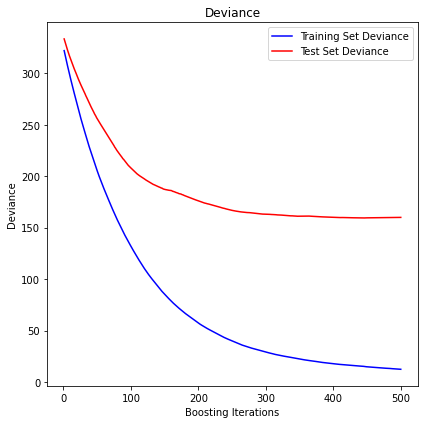

In [101]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_val_processed)):
    test_score[i] = reg.loss_(y_val, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Interpretation
Distributions between Prediction vs True

Val mean_squared_error 215151.0837064505


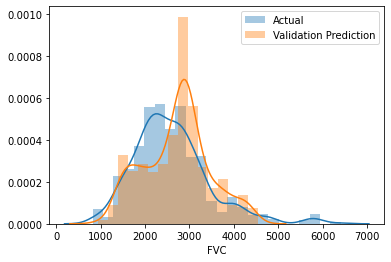

In [102]:
y_val_pred = search.best_estimator_.predict(X_val)

# print("Train mean_squared_error",mean_squared_error(y_train,y_train_pred))
print("Val mean_squared_error",mean_squared_error(y_val,y_val_pred))
sns.distplot(y_val, label='Actual')
sns.distplot(y_val_pred, label='Validation Prediction')
plt.legend();

## Interpretation
Feature Importance with LIME

In [105]:
y_val_diff = val[['Patient', 'FVC']]
y_val_diff['Prediction'] = y_val_pred
y_val_diff['Difference_Between_FVC_and_Prediction'] = y_val_diff['FVC'] - y_val_diff['Prediction']
y_val_diff.reset_index(inplace = True)
y_val_diff.sort_values(by=['Difference_Between_FVC_and_Prediction'], ascending = False).head(1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


index                    Patient   FVC   Prediction  \
273    822  ID00219637202258203123958  6399  4366.457479   

     Difference_Between_FVC_and_Prediction  
273                            2032.542521

## How features play out in a wrong prediction with too low of a FVC score

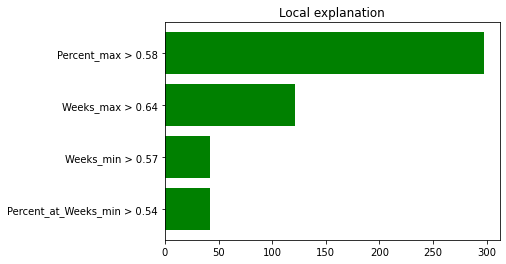

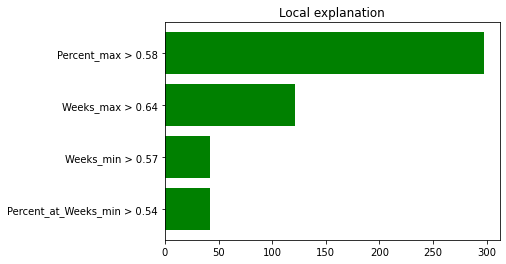

In [91]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(training_data=X_train_processed , feature_names=features, class_names="FVC", mode="regression")
explained = explainer.explain_instance(X_val_processed[273], reg.predict, num_features=4)
explained.as_pyplot_figure()

In [110]:
df.iloc[[822]]

Patient  Weeks   FVC     Percent  Age   Sex  \
822  ID00219637202258203123958      0  6399  153.012912   71  Male   

    SmokingStatus  Percent_max  Percent_at_Weeks_min  Weeks_max  Weeks_min  \
822     Ex-smoker   153.012912            134.218077         56          0   

     Percent_min  Age_Scaled  
822   153.012912          22

In [92]:
explained.show_in_notebook()

## How features play out in a wrong prediction with too high of a FVC score

In [104]:
y_val_diff.sort_values(by=['Difference_Between_FVC_and_Prediction'], ascending = False).tail(1)

index                    Patient   FVC   Prediction  \
300    886  ID00232637202260377586117  1977  3520.040284   

     Difference_Between_FVC_and_Prediction  
300                           -1543.040284

In [111]:
df.iloc[[886]]

Patient  Weeks   FVC     Percent  Age     Sex  \
886  ID00232637202260377586117     11  1977  119.542871   74  Female   

    SmokingStatus  Percent_max  Percent_at_Weeks_min  Weeks_max  Weeks_min  \
886  Never smoked   126.677954            104.728504         63          9   

     Percent_min  Age_Scaled  
886   115.431128          25

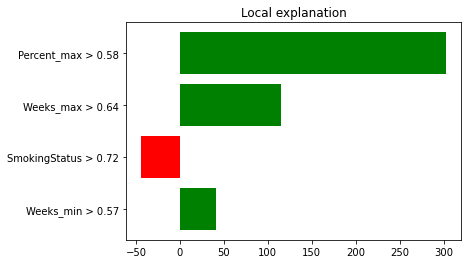

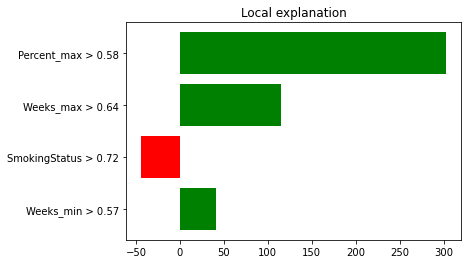

In [95]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train_processed , feature_names=features, class_names="FVC", mode="regression")
explained = explainer.explain_instance(X_val_processed[300], reg.predict, num_features=4)
explained.as_pyplot_figure()

In [112]:
df.iloc[[886]]

Patient  Weeks   FVC     Percent  Age     Sex  \
886  ID00232637202260377586117     11  1977  119.542871   74  Female   

    SmokingStatus  Percent_max  Percent_at_Weeks_min  Weeks_max  Weeks_min  \
886  Never smoked   126.677954            104.728504         63          9   

     Percent_min  Age_Scaled  
886   115.431128          25

In [96]:
explained = explainer.explain_instance(X_val_processed[300], reg.predict, num_features=4)
explained.show_in_notebook()

## How features play out in a more accurate prediction

In [116]:
y_val_diff[y_val_diff['Difference_Between_FVC_and_Prediction'] == y_val_diff['Difference_Between_FVC_and_Prediction'].median()]

index                    Patient   FVC   Prediction  \
224    603  ID00149637202232704462834  2965  3107.407403   

     Difference_Between_FVC_and_Prediction  
224                            -142.407403

In [120]:
df.iloc[[603]]

Patient  Weeks   FVC     Percent  Age     Sex  \
603  ID00149637202232704462834     60  2965  119.460113   66  Female   

    SmokingStatus  Percent_max  Percent_at_Weeks_min  Weeks_max  Weeks_min  \
603     Ex-smoker   130.821918            108.219178        100         44   

     Percent_min  Age_Scaled  
603   130.821918          17

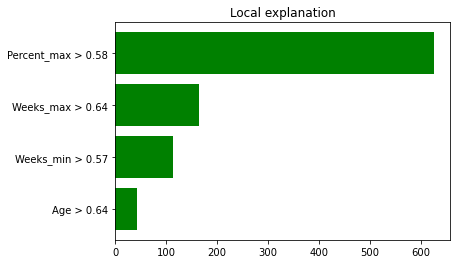

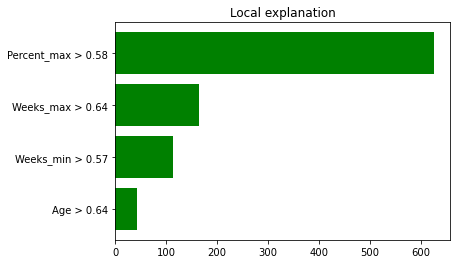

In [117]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train_processed , feature_names=features, class_names="FVC", mode="regression")
explained = explainer.explain_instance(X_val_processed[224], reg.predict, num_features=4)
explained.as_pyplot_figure()

In [121]:
df.iloc[[603]]

Patient  Weeks   FVC     Percent  Age     Sex  \
603  ID00149637202232704462834     60  2965  119.460113   66  Female   

    SmokingStatus  Percent_max  Percent_at_Weeks_min  Weeks_max  Weeks_min  \
603     Ex-smoker   130.821918            108.219178        100         44   

     Percent_min  Age_Scaled  
603   130.821918          17

In [118]:
explained = explainer.explain_instance(X_val_processed[224], reg.predict, num_features=4)
explained.show_in_notebook()

### Feature Importance

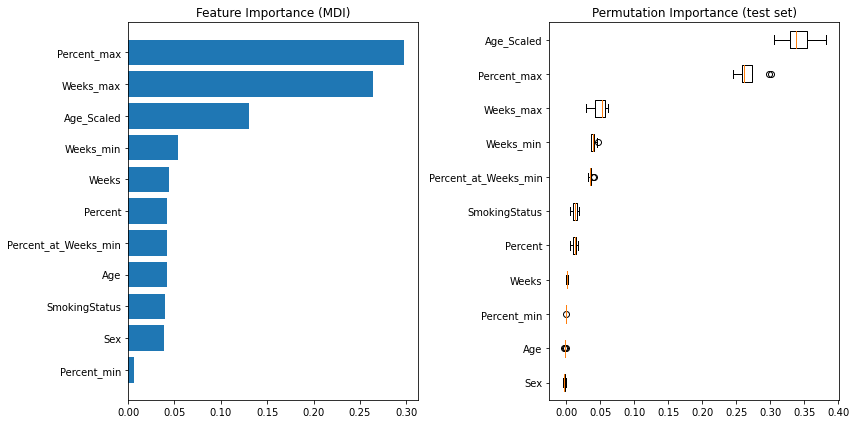

In [73]:
from sklearn.inspection import permutation_importance

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_val_processed, y_val, n_repeats=10,random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_train.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [126]:
X_train.head(2)

Weeks    Percent  Age   Sex SmokingStatus  Percent_max  \
0     -4  58.253649   79  Male     Ex-smoker    58.253649   
1      5  55.712129   79  Male     Ex-smoker    58.253649   

   Percent_at_Weeks_min  Weeks_max  Weeks_min  Percent_min  Age_Scaled  
0             50.327126         57         -4    58.253649          30  
1             50.327126         57         -4    58.253649          30

In [134]:
numeric_features = ['Weeks', 'Age', 'Weeks_max', 'Weeks_min', 'Age_Scaled','Percent', 'Percent_max', 'Percent_at_Weeks_min', 'Percent_min']

X_train[numeric_features]

Weeks  Age  Weeks_max  Weeks_min  Age_Scaled    Percent  Percent_max  \
0        -4   79         57         -4          30  58.253649    58.253649   
1         5   79         57         -4          30  55.712129    58.253649   
2         7   79         57         -4          30  51.862104    58.253649   
3         9   79         57         -4          30  53.950679    58.253649   
4        11   79         57         -4          30  52.063412    58.253649   
...     ...  ...        ...        ...         ...        ...          ...   
1544     13   73         59          0          24  66.594637    73.126412   
1545     19   73         59          0          24  73.126412    73.126412   
1546     31   73         59          0          24  71.407524    73.126412   
1547     43   73         59          0          24  73.052745    73.126412   
1548     59   73         59          0          24  68.117081    73.126412   

      Percent_at_Weeks_min  Percent_min  
0                50.327126    58.253649  
1                50.327126    58.253649  
2                50.327126    58.253649  
3                50.327126    58.253649  
4                50.327126    58.253649  
...                    ...          ...  
1544             66.594637    71.824968  
1545             66.594637    71.824968  
1546             66.594637    71.824968  
1547             66.594637    71.824968  
1548             66.594637    71.824968  

[1006 rows x 9 columns]

Automatically created module for IPython interactive environment


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)


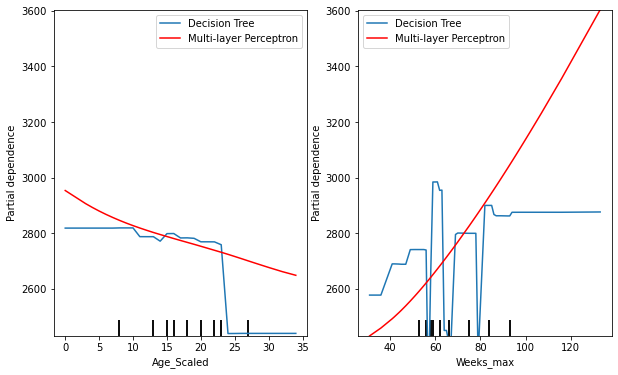

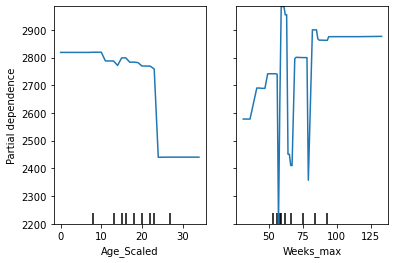

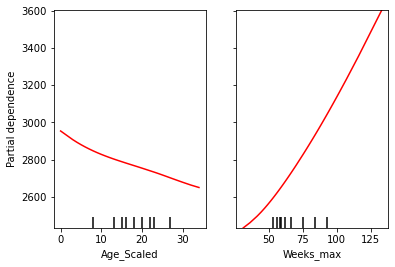

In [141]:
print(__doc__)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import plot_partial_dependence


numeric_features = ['Weeks', 'Age', 'Weeks_max', 'Weeks_min', 'Age_Scaled','Percent', 'Percent_max', 'Percent_at_Weeks_min', 'Percent_min']

tree = DecisionTreeRegressor()
mlp = make_pipeline(StandardScaler(),
                    MLPRegressor(hidden_layer_sizes=(100, 100),
                                 tol=1e-2, max_iter=500, random_state=0))
tree.fit(X_train[numeric_features], y_train)
mlp.fit(X_train[numeric_features], y_train)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
tree_disp = plot_partial_dependence(tree, X_train[numeric_features], ["Age_Scaled", "Weeks_max"])
mlp_disp = plot_partial_dependence(mlp, X_train[numeric_features], ["Age_Scaled", "Weeks_max"], line_kw={"c": "red"})
tree_disp.plot(ax=[ax1, ax2], line_kw={"label": "Decision Tree"})
mlp_disp.plot(ax=[ax1, ax2], line_kw={"label": "Multi-layer Perceptron",
                                      "c": "red"})
ax1.legend()
ax2.legend()

In [149]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('select', SelectKBest()),
    ('model', GradientBoostingRegressor(random_state=0, loss = 'quantile', criterion = 'mse', alpha = 0.5))])

param_grid = {
    'select__k': [2, 4, 6, 8, 10],
    'model__max_depth': [10, 12, 14, 16],
    'model__min_samples_leaf': [1, 10]}

search = GridSearchCV(
            pipe, 
            param_grid, 
            verbose=10,
            cv=5)
search05.fit(X_train, y_train)
y_val_pred_05 = search05.best_estimator_.predict(X_val)

NameError: name 'search05' is not defined

In [ ]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('select', SelectKBest()),
    ('model', GradientBoostingRegressor(random_state=0, loss = 'quantile', criterion = 'mse', alpha = 0.32))])

param_grid = {
    'select__k': [2, 4, 6, 8, 10],
    'model__max_depth': [10, 12, 14, 16],
    'model__min_samples_leaf': [1, 10]}

search32 = GridSearchCV(
            pipe, 
            param_grid, 
            verbose=10,
            cv=5)
search32.fit(X_train, y_train)
y_val_pred_32 = search32.best_estimator_.predict(X_val)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=2 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=2, score=0.692, total=   1.1s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=2 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=2, score=0.224, total=   1.4s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=2 .....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=2, score=-0.037, total=   1.6s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=2 .....


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=2, score=0.106, total=   1.4s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=2 .....


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=2, score=0.784, total=   1.1s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=4 .....


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.824, total=   1.7s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=4 .....


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.4s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.686, total=   1.8s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=4 .....


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.2s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=-0.063, total=   1.6s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=4 .....


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.9s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.121, total=   1.7s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=4 .....


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.6s remaining:    0.0s


[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=4, score=0.819, total=   1.6s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=6, score=0.823, total=   1.6s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=6, score=0.871, total=   1.9s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=6, score=0.643, total=   1.8s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=6, score=0.726, total=   1.9s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=10, model__min_samples_leaf=1, select__k=6, score=0.800, total=   1.8s
[CV] model__max_depth=10, model__min_samples_leaf=1, select__k=8 .....
[CV]  mode

[CV]  model__max_depth=12, model__min_samples_leaf=1, select__k=4, score=0.808, total=   2.4s
[CV] model__max_depth=12, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=12, model__min_samples_leaf=1, select__k=6, score=0.822, total=   2.6s
[CV] model__max_depth=12, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=12, model__min_samples_leaf=1, select__k=6, score=0.881, total=   2.6s
[CV] model__max_depth=12, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=12, model__min_samples_leaf=1, select__k=6, score=0.692, total=   2.6s
[CV] model__max_depth=12, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=12, model__min_samples_leaf=1, select__k=6, score=0.722, total=   2.3s
[CV] model__max_depth=12, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=12, model__min_samples_leaf=1, select__k=6, score=0.811, total=   2.3s
[CV] model__max_depth=12, model__min_samples_leaf=1, select__k=8 .....
[CV]  mode

[CV]  model__max_depth=14, model__min_samples_leaf=1, select__k=4, score=0.798, total=   2.6s
[CV] model__max_depth=14, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=14, model__min_samples_leaf=1, select__k=6, score=0.829, total=   2.9s
[CV] model__max_depth=14, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=14, model__min_samples_leaf=1, select__k=6, score=0.870, total=   2.5s
[CV] model__max_depth=14, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=14, model__min_samples_leaf=1, select__k=6, score=0.674, total=   2.5s
[CV] model__max_depth=14, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=14, model__min_samples_leaf=1, select__k=6, score=0.737, total=   2.8s
[CV] model__max_depth=14, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=14, model__min_samples_leaf=1, select__k=6, score=0.813, total=   2.8s
[CV] model__max_depth=14, model__min_samples_leaf=1, select__k=8 .....
[CV]  mode

[CV]  model__max_depth=16, model__min_samples_leaf=1, select__k=4, score=0.797, total=   3.4s
[CV] model__max_depth=16, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=16, model__min_samples_leaf=1, select__k=6, score=0.822, total=   3.6s
[CV] model__max_depth=16, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=16, model__min_samples_leaf=1, select__k=6, score=0.883, total=   3.3s
[CV] model__max_depth=16, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=16, model__min_samples_leaf=1, select__k=6, score=0.696, total=   3.9s
[CV] model__max_depth=16, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=16, model__min_samples_leaf=1, select__k=6, score=0.731, total=   3.4s
[CV] model__max_depth=16, model__min_samples_leaf=1, select__k=6 .....
[CV]  model__max_depth=16, model__min_samples_leaf=1, select__k=6, score=0.805, total=   3.6s
[CV] model__max_depth=16, model__min_samples_leaf=1, select__k=8 .....
[CV]  mode

In [ ]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('select', SelectKBest()),
    ('model', GradientBoostingRegressor(random_state=0, loss = 'quantile', criterion = 'mse', alpha = 0.68))])

param_grid = {
    'select__k': [2, 4, 6, 8, 10],
    'model__max_depth': [10, 12, 14, 16],
    'model__min_samples_leaf': [1, 10]}

search68 = GridSearchCV(
            pipe, 
            param_grid, 
            verbose=10,
            cv=5)
search68.fit(X_train, y_train)
y_val_pred_68 = search68.best_estimator_.predict(X_val)

In [ ]:
# # print("Train mean_squared_error",mean_squared_error(y_train,y_train_pred))
print("Val mean_squared_error",mean_squared_error(y_val,y_val_pred_05))
sns.distplot(y_val, label='Actual')
sns.distplot(y_val_pred_05, label='Median Prediction')
sns.distplot(y_val_pred_32, label='32 StDev Prediction')
sns.distplot(y_val_pred_68, label='68 StDev Prediction')
plt.legend();

<img src="https://imgur.com/B3gwVf8.jpg" width="600">

In [ ]:
s = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
standard_deviation = s['Confidence'][0]

σ = max(standard_deviation, 70)

actual_FVC_value = 1500 # pretended actual number
# pretended actual number 1500 - the first observation 1127 = 373
# the absolute value of 373 is smaller than 1000
Δ = min(abs(actual_FVC_value - s['FVC'][0]), 1000)

metric = (math.sqrt(2) * Δ / σ) - np.log(math.sqrt(2) * σ)
metric

In [23]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
test = pd.merge(sub, test, on = ['Patient'], how='outer')

test.rename(columns = {'Weeks_x':'Weeks'}, inplace = True)

def wrangle(df):
    max_Percent = df[['Patient','Percent']].sort_values('Percent', ascending=False).drop_duplicates(['Patient'])
    min_Percent = df[['Patient','Percent']].sort_values('Percent', ascending=True).drop_duplicates(['Patient'])
    max_Weeks = df[['Patient','Weeks']].sort_values('Weeks', ascending=False).drop_duplicates(['Patient'])
    min_Weeks = df[['Patient','Weeks','Percent']].sort_values('Weeks', ascending=True).drop_duplicates(['Patient'])

    df = pd.merge(df, max_Percent, how='left', on=['Patient'], suffixes=(None, '_max'))
    df = pd.merge(df, min_Percent, how='left', on=['Patient'], suffixes=(None, '_at_Weeks_min',))
    df = pd.merge(df, max_Weeks, how='left', on=['Patient'], suffixes=(None, '_max'))
    df = pd.merge(df, min_Weeks, how='left', on=['Patient'], suffixes=(None, '_min'))

    # df['Weekly_Avg_Percent_Change'] = (df['Percent_max'] - df['Percent_min']) / (df['Weeks_max'] - df['Weeks_min']) * -1

    age = df['Age'].min()
    converted_age = getattr(age, "tolist", lambda: age)()
    df['Age_Scaled'] = df['Age'].astype(int) - converted_age
    return df
test = wrangle(test)
test.drop(columns = ['Patient_Week', 'Patient','FVC_x','Confidence','Weeks_y','FVC_y'], inplace=True)

test.head(3)

Weeks    Percent  Age   Sex SmokingStatus  Percent_max  \
0    -12  70.186855   73  Male     Ex-smoker    70.186855   
1    -11  70.186855   73  Male     Ex-smoker    70.186855   
2    -10  70.186855   73  Male     Ex-smoker    70.186855   

   Percent_at_Weeks_min  Weeks_max  Weeks_min  Percent_min  Age_Scaled  
0             70.186855        133        -12    70.186855           5  
1             70.186855        133        -12    70.186855           5  
2             70.186855        133        -12    70.186855           5

In [24]:
s = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

y_pred = search.best_estimator_.predict(test)
sub = s[['Patient_Week']]
sub['FVC'] = y_pred
sub['Confidence'] = sub['FVC'].std()
sub['FVC'] = sub['FVC'].astype(int)
sub['Confidence'] = sub['Confidence'].astype(int)
sub.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Patient_Week   FVC  Confidence
0  ID00419637202311204720264_-12  2767         178
1  ID00421637202311550012437_-12  2767         178

In [25]:
sub.to_csv("submission.csv", index=False)
a = pd.read_csv('./submission.csv')
a.sample(10)

Patient_Week   FVC  Confidence
597  ID00422637202311677017371_107  2919         178
244   ID00426637202313170790466_36  3127         178
213   ID00423637202312137826377_30  2960         178
343   ID00423637202312137826377_56  2860         178
651  ID00421637202311550012437_118  2951         178
639  ID00426637202313170790466_115  2975         178
188   ID00423637202312137826377_25  2984         178
380   ID00419637202311204720264_64  2835         178
134   ID00426637202313170790466_14  2724         178
118   ID00423637202312137826377_11  2692         178